<a href="https://colab.research.google.com/github/reubenwenisch/VisionTransformer/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install linformer
!pip install vit-pytorch
!pip install kaggle==1.5.12

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd '/content/gdrive/MyDrive/Learn/VisionTransformer'

/content/gdrive/MyDrive/Learn/VisionTransformer


### Data download from kaggle

> Indented block



In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions download -c dogs-vs-cats

In [4]:
# import zipfile

# with zipfile.ZipFile('dogs-vs-cats.zip') as train_zip:
#     train_zip.extractall('data')

### Import Libraries

In [4]:
import random
import pandas as pd

# import Linformer
from linformer import Linformer
from itertools import chain
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#sklearn to split the data
from sklearn.model_selection import train_test_split   

### Config Params

In [5]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 
seed = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

### Download data and Spitting them

In [6]:
from utils import download_data
from utils import img_show

train_list, test_list = download_data(unzip=False)
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
#Splitting train and validation list
train_list, valid_list = train_test_split(train_list, test_size=0.2, stratify=labels, random_state=seed)
Print("Data Split for Train, Val, Test")
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500
Train Data: 20000
Validation Data: 5000
Test Data: 12500


#### Display images

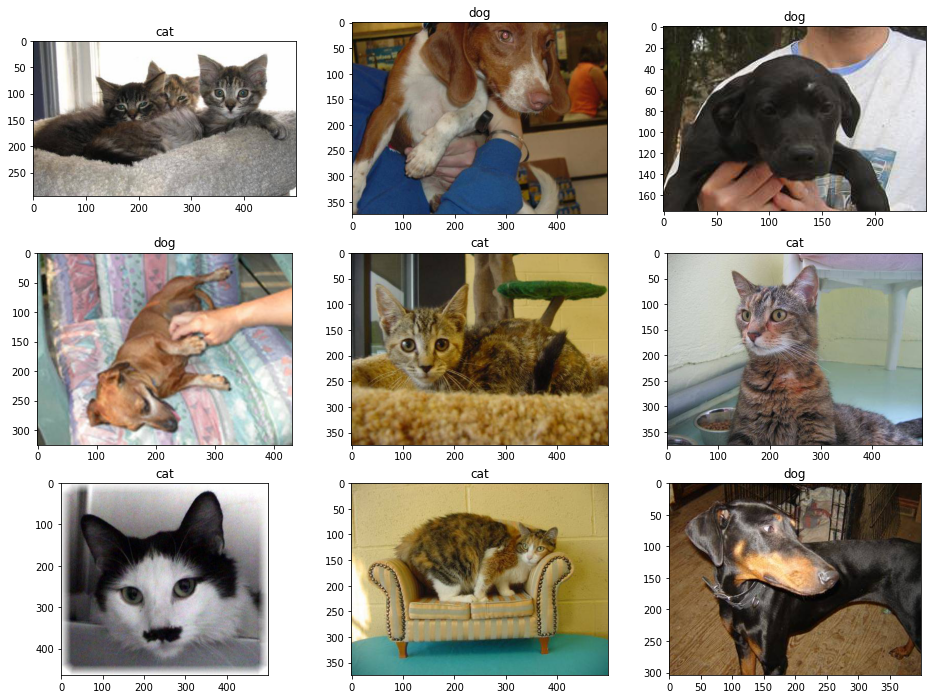

In [7]:
#Defining labels
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
img_show(train_list, labels)

In [8]:
from utils import CatsDogsDataset
#defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

#loading dataloader
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [9]:
#Line transformer
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [10]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer
scheduler = StepLR(optimizer, step_size=1, gamma=gamma) # scheduler

In [11]:
from utils import train
for epoch in range(epochs):
    train(train_loader, valid_loader, device, model, criterion, optimizer, epoch)
print("Training Complete")

100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Epoch : 1 - loss : 0.6965 - acc: 0.5084 - val_loss : 0.6918 - val_acc: 0.5198



100%|██████████| 313/313 [03:19<00:00,  1.57it/s]


Epoch : 2 - loss : 0.6926 - acc: 0.5166 - val_loss : 0.6885 - val_acc: 0.5259



100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Epoch : 3 - loss : 0.6871 - acc: 0.5401 - val_loss : 0.6783 - val_acc: 0.5767



100%|██████████| 313/313 [03:22<00:00,  1.55it/s]


Epoch : 4 - loss : 0.6761 - acc: 0.5775 - val_loss : 0.6659 - val_acc: 0.5963



100%|██████████| 313/313 [03:22<00:00,  1.55it/s]


Epoch : 5 - loss : 0.6726 - acc: 0.5774 - val_loss : 0.6677 - val_acc: 0.5837



100%|██████████| 313/313 [03:22<00:00,  1.54it/s]


Epoch : 6 - loss : 0.6626 - acc: 0.5945 - val_loss : 0.6578 - val_acc: 0.6084



100%|██████████| 313/313 [03:25<00:00,  1.53it/s]


Epoch : 7 - loss : 0.6576 - acc: 0.6024 - val_loss : 0.6461 - val_acc: 0.6100



100%|██████████| 313/313 [03:21<00:00,  1.55it/s]


Epoch : 8 - loss : 0.6512 - acc: 0.6071 - val_loss : 0.6462 - val_acc: 0.6187



100%|██████████| 313/313 [03:21<00:00,  1.55it/s]


Epoch : 9 - loss : 0.6436 - acc: 0.6190 - val_loss : 0.6393 - val_acc: 0.6240



100%|██████████| 313/313 [03:23<00:00,  1.54it/s]


Epoch : 10 - loss : 0.6403 - acc: 0.6244 - val_loss : 0.6325 - val_acc: 0.6329



100%|██████████| 313/313 [03:21<00:00,  1.55it/s]


Epoch : 11 - loss : 0.6319 - acc: 0.6346 - val_loss : 0.6203 - val_acc: 0.6501



100%|██████████| 313/313 [03:26<00:00,  1.51it/s]


Epoch : 12 - loss : 0.6277 - acc: 0.6387 - val_loss : 0.6243 - val_acc: 0.6470



100%|██████████| 313/313 [03:19<00:00,  1.57it/s]


Epoch : 13 - loss : 0.6185 - acc: 0.6491 - val_loss : 0.6263 - val_acc: 0.6475



100%|██████████| 313/313 [03:18<00:00,  1.58it/s]


Epoch : 14 - loss : 0.6096 - acc: 0.6566 - val_loss : 0.6085 - val_acc: 0.6626



100%|██████████| 313/313 [03:22<00:00,  1.54it/s]


Epoch : 15 - loss : 0.6067 - acc: 0.6629 - val_loss : 0.6057 - val_acc: 0.6650



100%|██████████| 313/313 [03:25<00:00,  1.52it/s]


Epoch : 16 - loss : 0.6016 - acc: 0.6685 - val_loss : 0.6026 - val_acc: 0.6667



100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Epoch : 17 - loss : 0.5978 - acc: 0.6734 - val_loss : 0.6002 - val_acc: 0.6620



100%|██████████| 313/313 [03:25<00:00,  1.52it/s]


Epoch : 18 - loss : 0.5957 - acc: 0.6688 - val_loss : 0.5969 - val_acc: 0.6721



100%|██████████| 313/313 [03:26<00:00,  1.52it/s]


Epoch : 19 - loss : 0.5919 - acc: 0.6789 - val_loss : 0.5914 - val_acc: 0.6786



100%|██████████| 313/313 [03:16<00:00,  1.60it/s]


Epoch : 20 - loss : 0.5918 - acc: 0.6781 - val_loss : 0.5851 - val_acc: 0.6830

Training Complete
